# 3.3 ベイズ線形回帰
## 3.3.1 パラメータの分布

P152 ~ 154あたりの手順を再現

In [189]:
from __future__ import division
import scipy.stats

### 計算部品

xから計画行列$\Phi$を作る関数

In [269]:
def design_matrix(x):
    return np.array([[1, xi] for xi in x])

$m_N = \beta S_N\Phi^{T}t$ を求める関数

In [270]:
def calc_mn(alpha, beta, x, t):
    Phi = design_matrix(x)
    Sn = calc_Sn(alpha, beta, x)
    return beta * Sn.dot(Phi.T).dot(t)

$S_N = (\alpha I + \beta\Phi^{T}\Phi)^{-1}$ を求める関数

In [271]:
def calc_Sn(alpha, beta, x):
    Phi = design_matrix(x)
    return np.linalg.inv(alpha*I + beta*Phi.T.dot(Phi))

I = np.identity(2)

各プロット作成関数

In [272]:
def plot_probability(mean=[0, 0], cov=I, title='', ax=None):
    """
    確率分布のプロット
    """
    w0 = np.linspace(-1, 1, 100)
    w1 = np.linspace(-1, 1, 100)
    W0,W1 = np.meshgrid(w0, w1)
    P = []
    for w0i in w0:
        P.append([scipy.stats.multivariate_normal.pdf([w0i,w1i], mean, cov) for w1i in w1])
        
    ax.pcolor(W0, W1, np.array(P).T, cmap=plt.cm.jet)
    ax.set_xlabel('$w_0$')
    ax.set_ylabel('$w_1$')
    ax.set_title(title)

In [273]:
def calc_likelifood(beta, t, x, w):
    """
    観測値1つの対数尤度を求める
    """
    w = np.array(w)
    phi_x = np.array([1, x])
    return -1 * beta / 2 * (t - w.T.dot(phi_x))**2

def plot_likelifood(beta, t, x, title='', ax=None):
    """
    観測値の尤度のプロット
    """
    w0 = np.linspace(-1, 1, 100)
    w1 = np.linspace(-1, 1, 100)
    W0,W1 = np.meshgrid(w0, w1)
    L = []
    for w0i in w0:
        L.append([calc_likelifood(beta, t, x, [w0i, w1i]) for w1i in w1])

    ax.pcolor(W0, W1, np.array(L).T, cmap=plt.cm.jet, vmax=0, vmin=-1)
    ax.set_xlabel('$w_0$')
    ax.set_ylabel('$w_1$')
    ax.set_title(title)

In [274]:
def plot_result_line(w, ax):
    x = np.linspace(-1, 1, 100)
    y = w[0] + x*w[1]
    ax.plot(x, y)

In [275]:
def plot_lines(mean, cov, ax):
    plot_result_line(np.random.multivariate_normal(mean, cov), ax)
    plot_result_line(np.random.multivariate_normal(mean, cov), ax)
    plot_result_line(np.random.multivariate_normal(mean, cov), ax)
    plot_result_line(np.random.multivariate_normal(mean, cov), ax)
    plot_result_line(np.random.multivariate_normal(mean, cov), ax)
    plot_result_line(np.random.multivariate_normal(mean, cov), ax)
    for x, t in zip(train_x, train_t):
        ax.plot(x, t, 'ro')
        
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(u'データ空間')

観測データの生成用、真のモデル $y = -0.3 + 0.5x + Noise$ から作る

In [276]:
def uniform_sample():
    return (np.random.random() - 0.5) * 2

def create_train_data():
    def f(x, a):
        return a[0] + a[1]*x + np.random.normal(0, 0.2)

    x = uniform_sample()
    t = f(x, [-0.3, 0.5])
    return x, t

## 初期状態

In [281]:
ALPHA = 2.0
SIGMA = 0.2
BETA = 1/SIGMA**2 # 精度パラメータ
m0 = [0, 0]
s0 = ALPHA*I
train_x = []
train_t = []

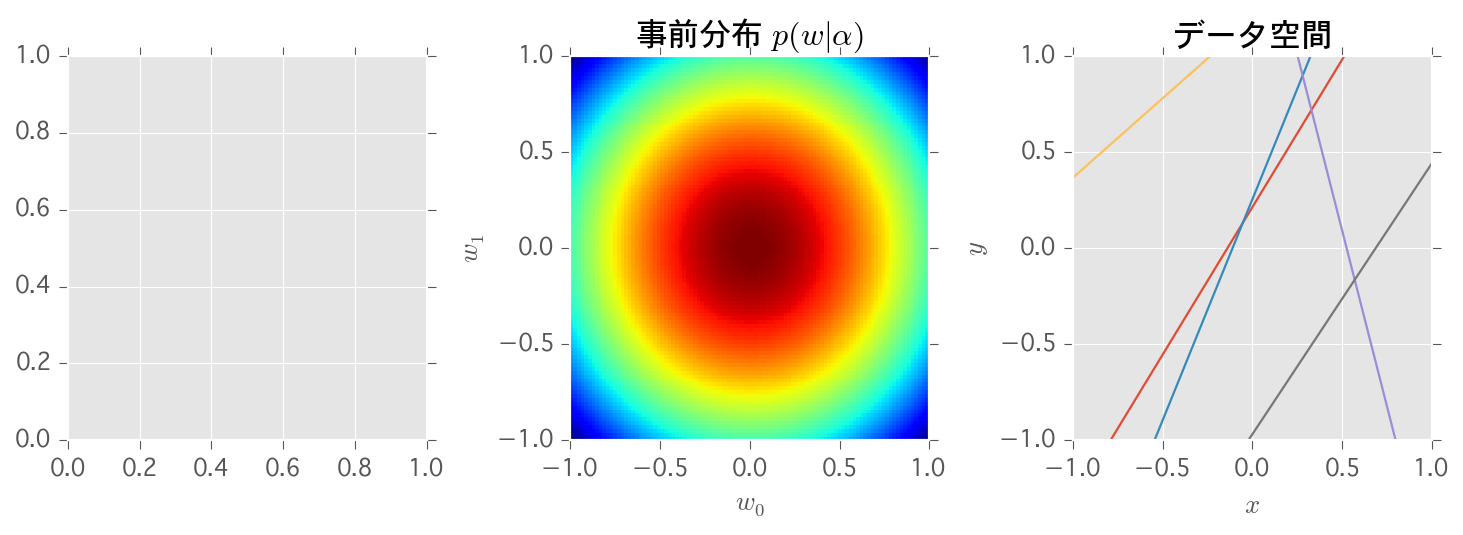

In [282]:
fig, axis = plt.subplots(1, 3, figsize=(11, 3))
plt.subplots_adjust(wspace=0.4)
plot_probability(mean=m0, cov=s0, title=u'事前分布 $p(w|\\alpha)$', ax=axis[1])
plot_lines(m0, s0, ax=axis[2])

## データ取得後

In [283]:
x, t = create_train_data()
train_x.append(x)
train_t.append(t)

$m_1$と$S_1$を求める

In [284]:
m1 = calc_mn(alpha=ALPHA, beta=BETA, x=train_x, t=train_t)
s1 = calc_Sn(alpha=ALPHA, beta=BETA, x=train_x)

モデルパラメータ$w$の事後分布 $p(w|t) = Norm(w|m_N, S_N)$ を求める

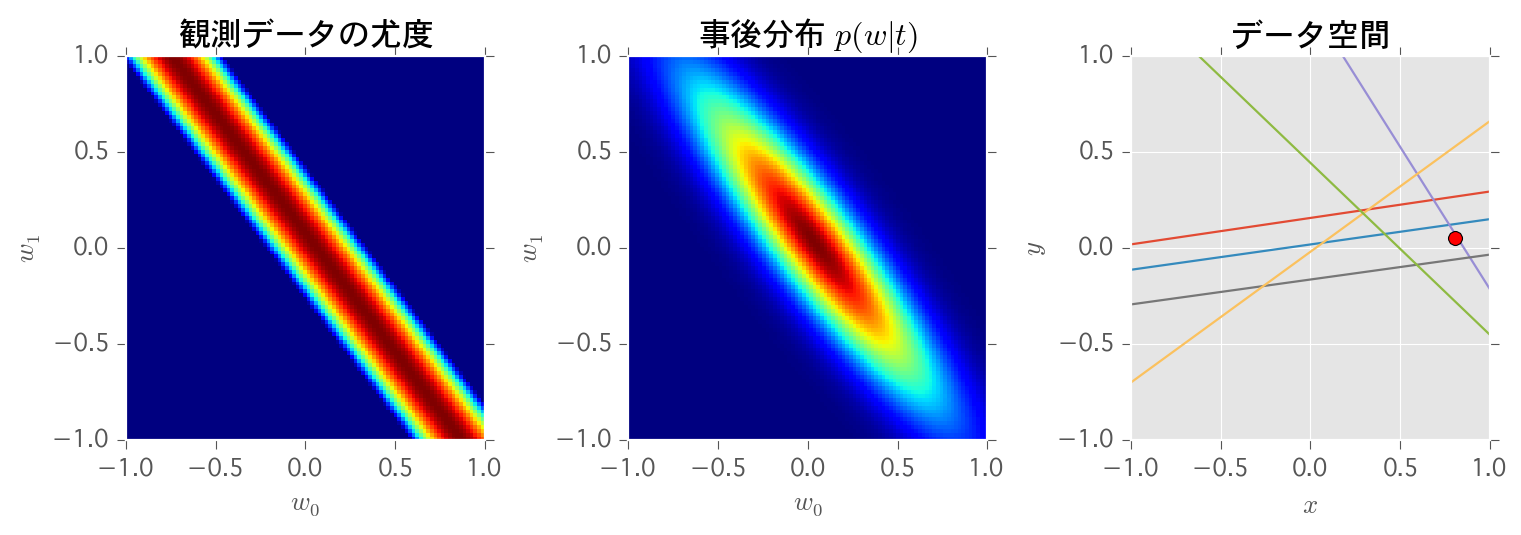

In [285]:
fig, axis = plt.subplots(1, 3, figsize=(11, 3))
plt.subplots_adjust(wspace=0.4)
plot_likelifood(beta=BETA, t=train_t[-1], x=train_x[-1], title=u'観測データの尤度', ax=axis[0])
plot_probability(mean=m1, cov=s1, title=u'事後分布 $p(w|t)$', ax=axis[1])
plot_lines(m1, s1, ax=axis[2])

## 2回目の更新

In [264]:
x, t = create_train_data()
train_x.append(x)
train_t.append(t)
m2 = calc_mn(alpha=ALPHA, beta=BETA, x=train_x, t=train_t)
s2 = calc_Sn(alpha=ALPHA, beta=BETA, x=train_x)

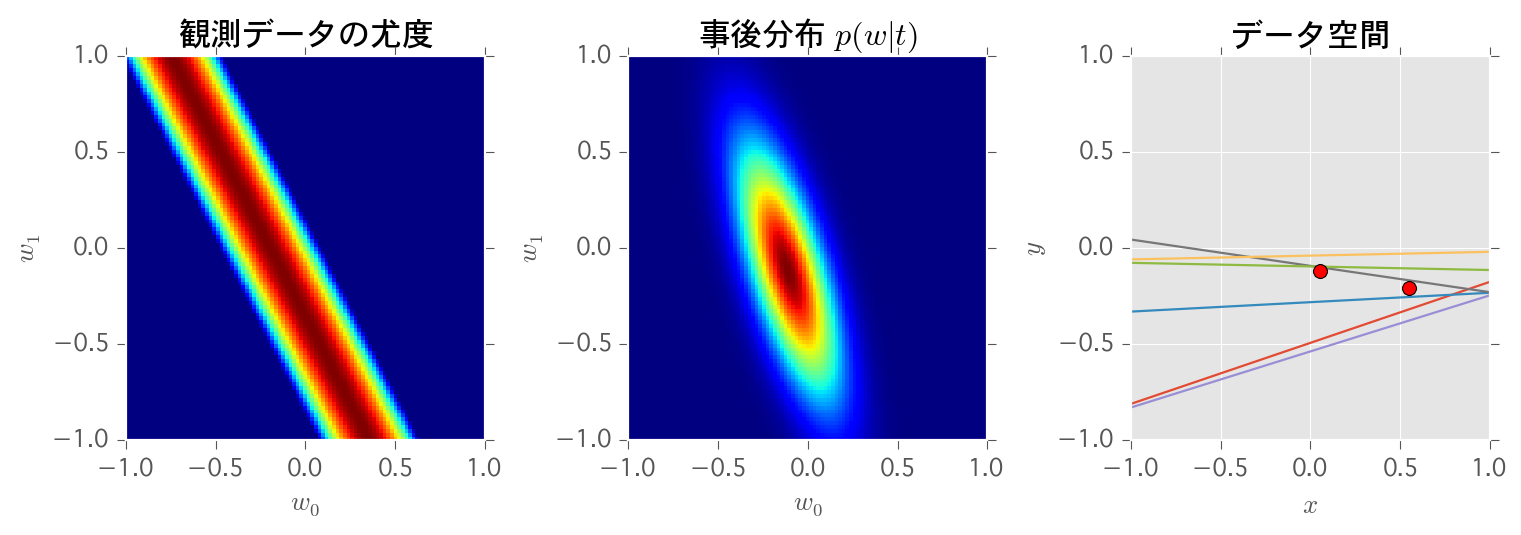

In [265]:
fig, axis = plt.subplots(1, 3, figsize=(11, 3))
plt.subplots_adjust(wspace=0.4)
plot_likelifood(beta=BETA, t=train_t[-1], x=train_x[-1], title=u'観測データの尤度', ax=axis[0])
plot_probability(mean=m2, cov=s2, title=u'事後分布 $p(w|t)$', ax=axis[1])
plot_lines(m2, s2, ax=axis[2])

## モデルパラメータの事後確率$p(w|t)$の収束

In [266]:
def update(train_x, train_t):
    x, t = create_train_data()
    train_x.append(x)
    train_t.append(t)
    mn = calc_mn(alpha=ALPHA, beta=BETA, x=train_x, t=train_t)
    sn = calc_Sn(alpha=ALPHA, beta=BETA, x=train_x)
    return mn, sn

In [267]:
update(train_x, train_t)
update(train_x, train_t)
update(train_x, train_t)
update(train_x, train_t)
update(train_x, train_t)
mn, sn = update(train_x, train_t)

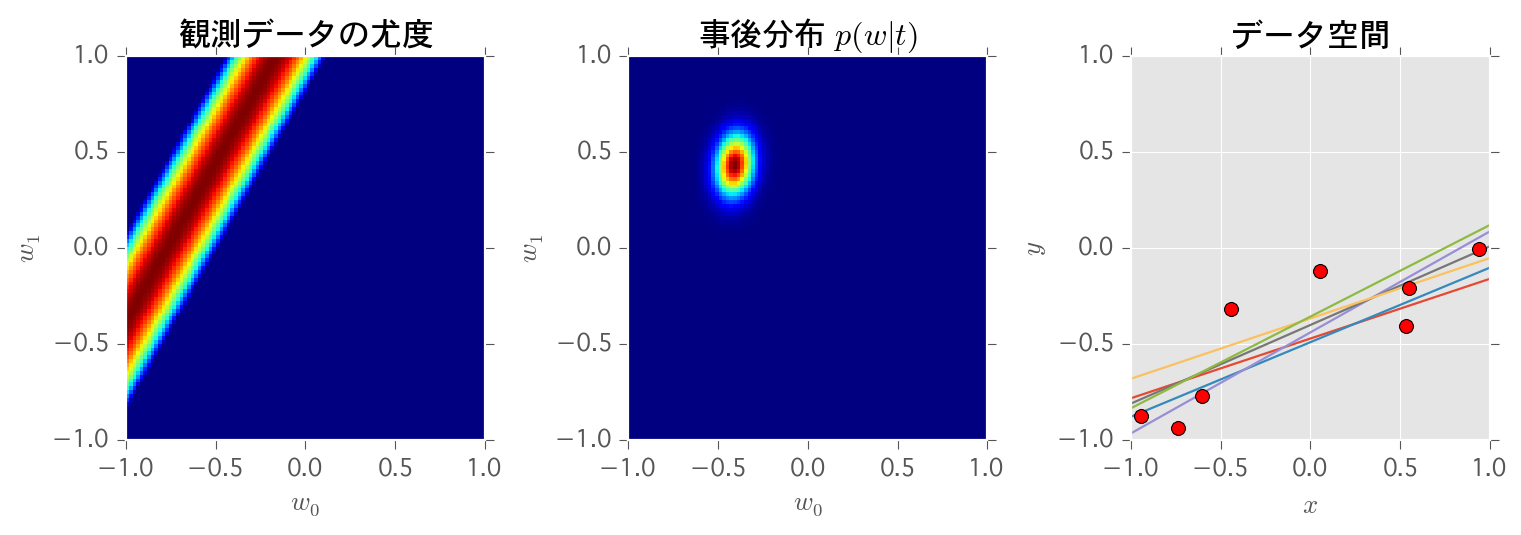

In [268]:
fig, axis = plt.subplots(1, 3, figsize=(11, 3))
plt.subplots_adjust(wspace=0.4)
plot_likelifood(beta=BETA, t=train_t[-1], x=train_x[-1], title=u'観測データの尤度', ax=axis[0])
plot_probability(mean=mn, cov=sn, title=u'事後分布 $p(w|t)$', ax=axis[1])
plot_lines(mn, sn, ax=axis[2])

$p(w|t)$がモデルの真のパラメータ $w_0 = -0.3, w_1 = 0.5$ 付近に収束した 